# Một số lưu ý khi dùng tham khảo.
### 1. Dữ liệu chỉ cần dưới định dạng: date | open | high | low | close. Không phân biệt thị trường chứng khoán hay crypto miễn là có file csv. Người xem có thể tự download dữ liệu trên các trang mạng về.
### 2. Bản báo cáo này chưa được tối ưu do chưa có chức năng tự động update giá. => chưa thể tự cập nhập dự đoán.

In [69]:
import btalib
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

In [70]:
# load DataFrame
btc_df = pd.read_csv('btc_bars4.csv', index_col=0)
btc_df.index = pd.to_datetime(btc_df.index, unit='ms')

## 1. SMA
Non-weighted average of the last n periods

Formula:
  - movav = Sum(data, period) / period

See also:
  - http://en.wikipedia.org/wiki/Moving_average#Simple_moving_average


Aliases: SMA, SimpleMovingAverage

Inputs: close

Outputs: sma

Params:
  - period (default: 30)
    Period for the moving average calculation

In [71]:
sma = btalib.sma(btc_df.close)

## 2. RSI
Defined by J. Welles Wilder, Jr. in 1978 in his book *"New Concepts in
Technical Trading Systems"*.

It measures momentum by calculating the ration of higher closes and
lower closes after having been smoothed by an average, normalizing
the result between 0 and 100

Formula:
  - up = upday(data)  # max(close - close(-1), 0.0)
  - down = downday(data)  # abs( min(close - close(-1), 0.0) )
  - maup = movingaverage(up, period)
  - madown = movingaverage(down, period)
  - rs = maup / madown
  - rsi = 100 - 100 / (1 + rs)

The moving average used is the one originally defined by Wilder,
the SmoothedMovingAverage

See:
  - http://en.wikipedia.org/wiki/Relative_strength_index


Aliases: RSI, RelativeStrengthIndex

Inputs: close

Outputs: rsi

Params:
  - period (default: 14)
    Period to consider
  - lookback (default: 1)
    Lookback for up/down days
  - _ma (default: smma)
    Smoothing moving average

In [72]:
rsi = btalib.rsi(btc_df, period=14)

## 3. Stoch RSI
Presented by Chande and Kroll the 1990 book: "The New Technical Trader".
The RSI is fed into a atochastic-like calculation to increase its
sensitivity.

The recommendation is to keep the period for looking for highest highes and
lowest lows the same as the for the RSI, but it can be played with for
experimentation.

Scaling to 100 is also suggested as a possiblity (the range is 0.0 => 1.0)

Formula:

  - rsi = RSI(data, period)
  - maxrsi = Highest(rsi, period)
  - minrsi = Lowest(rsi, period)

  - stochrsi = (rsi - minrsi) / (maxrsi - minrsi)

See
  - https://school.stockcharts.com/doku.php?id=technical_indicators:stochrsi


Aliases: StochRsi, STOCHRSI

Inputs: close

Outputs: stochrsi

Params:
  - period (default: 14)
    Period to consider
  - _philo (default: None)
    Period for highest/lowest (None => period)
  - _scale (default: 1.0)
    Scale the result by this factor

TA-LIB (with compatibility flag "_talib=True"):


ta-lib uses internally the fast stochastic to calculate the stochrsi,
with these side-effects

  - The scale changes from 0.0-1.0 to 0.0-100.0

  - A 2nd output is returned (stochrsi as defined by its authors has
    only 1 output)

  - The highest/lowest period is no longer symmetric with the rsi
    period

Compatibility does this
  - Change the scale to 0.0-100.0
  - Change the highest/lowest period 5
  - Add a 2nd output named 'd' (as the 2nd output of the stochastic)
  - Run a simple moving average on it of period 3

In [73]:
stochrsi = btalib.stochrsi(btc_df, period=14)

## 4. CCI
Introduced by Donald Lambert in 1980 to measure variations of the
"typical price" (see below) from its mean to identify extremes and
reversals

Formula:
  - tp = typical_price = (high + low + close) / 3
  - tpmean = MovingAverage(tp, period)
  - deviation = tp - tpmean
  - meandev = MeanDeviation(tp)
  - cci = deviation / (meandeviation * factor)

See:
  - https://en.wikipedia.org/wiki/Commodity_channel_index


Aliases: CCI, CommodityChannelIndex

Inputs: high, low, close

Outputs: cci

Params:
  - period (default: 20)
    Period to consider
  - factor (default: 0.015)
    Channel width factor
  - _ma (default: sma)
    Moving Average to sue
  - _dev (default: mad)
    Deviation to use (Def: Mean Abs Dev)

TA-LIB (with compatibility flag "_talib=True"):

Change period to 14

In [74]:
cci = btalib.cci(btc_df, period = 20, factor = 0.015)

## 5. Parabol SAR
Defined by J. Welles Wilder, Jr. in 1978 in his book *"New Concepts in
Technical Trading Systems"* for the RSI

SAR stands for *Stop and Reverse* and the indicator was meant as a signal
for entry (and reverse)

How to select the 1st signal is left unspecified in the book. Because the
inputs are "high" and "low", a 1-bar MinusDM is calculated, which accounts
for both downmove and upmove of high/low. This is also done by ta-lib

See:
  - https://en.wikipedia.org/wiki/Parabolic_SAR
  - http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:parabolic_sar


Aliases: SAR, psar, ParabolicStopAndReverse

Inputs: high, low

Outputs: sar

Params:
  - af (default: 0.02)
    Acceleration Factor
  - afmax (default: 0.2)
    Maximum Acceleration Factor

In [75]:
sar = btalib.sar(btc_df)

## 6. MACD
Moving Average Convergence Divergence. Defined by Gerald Appel in the 70s.

It measures the distance of a fast and a slow moving average to try to
identify the trend.

A second lagging moving average over the convergence-divergence should
provide a "signal" upon being crossed by the macd

Formula:
  - macd = ma(data, pfast) - ma(data, pslow)
  - signal = ma(macd, psignal)
  - histogram = macd - signal

See:
  - http://en.wikipedia.org/wiki/MACD


Aliases: MACD, MovingAverageConvergenceDivergence, MACDEXT, MACDFIX

Inputs: close

Outputs: macd, signal, histogram

Params:
  - pfast (default: 12)
    Fast moving average period
  - pslow (default: 26)
    Slow moving average period
  - psignal (default: 9)
    Signal smoothing period
  - _ma (default: ema)
    Moving average to use
  - _masig (default: None)
    Signal moving average (if `None`, same as others)

TA-LIB (with compatibility flag "_talib=True"):

Start fast ema calc delivery at the offset of the slow ema

In [76]:
macd = btalib.macd(btc_df, pfast=20, pslow=50, psignal=13)

In [77]:
# join the rsi and macd calculations as columns in original df
btc_df = btc_df.join([sma.df ,rsi.df,stochrsi.df, cci.df, sar.df, macd.df])


In [78]:
btc_df = btc_df.reset_index()

In [79]:
btc_df

,date,open,high,low,close,sma,rsi,stochrsi,cci,sar,macd,signal,histogram
0,2021-12-03 13:00:00,56869.60,58801.00,15000.00,56860.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-12-03 14:00:00,56863.20,56926.68,25172.90,56239.13,NaN,NaN,NaN,NaN,15000.000000,NaN,NaN,NaN
2,2021-12-03 15:00:00,56193.15,56346.63,34727.40,55980.14,NaN,NaN,NaN,NaN,15838.533600,NaN,NaN,NaN
3,2021-12-03 16:00:00,55965.90,55965.91,22643.66,54979.99,NaN,NaN,NaN,NaN,16660.296528,NaN,NaN,NaN
4,2021-12-03 17:00:00,54990.24,55080.18,43000.80,54981.54,NaN,NaN,NaN,NaN,17465.624197,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,2021-12-29 21:00:00,47358.95,47502.57,36691.24,47208.52,47700.062333,39.938752,0.567213,-89.118954,150000.000000,-789.509302,-846.366085,56.856783
633,2021-12-29 22:00:00,47208.52,47562.18,36691.24,47274.45,47654.945333,41.173006,0.632504,-84.591837,147733.824800,-780.263875,-836.922912,56.659037
634,2021-12-29 23:00:00,47272.54,47371.70,46104.52,46466.49,47602.814000,32.388891,0.167834,-41.000094,145512.973104,-814.576715,-833.730598,19.153883
635,2021-12-30 00:00:00,46464.66,46796.96,45392.32,46692.67,47566.003000,36.474728,0.383971,-45.044464,143336.538442,-828.690764,-833.010622,4.319857


In [80]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       637 non-null    datetime64[ns]
 1   open       637 non-null    float64       
 2   high       637 non-null    float64       
 3   low        637 non-null    float64       
 4   close      637 non-null    float64       
 5   sma        608 non-null    float64       
 6   rsi        623 non-null    float64       
 7   stochrsi   610 non-null    float64       
 8   cci        618 non-null    float64       
 9   sar        636 non-null    float64       
 10  macd       588 non-null    float64       
 11  signal     576 non-null    float64       
 12  histogram  576 non-null    float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 64.8 KB


In [81]:
feature = ["rsi", "stochrsi", "cci", "sar", "macd", "signal", "histogram", "sma"]
# feature = ["rsi", "stochrsi", "cci", "sar"]
# feature = ["rsi", "stochrsi", "sar"]
data_X = btc_df[feature].iloc[61: ]  # 61 là nơi mà Nan của các chỉ báo.
                                #Sẽ cải tiến cho trường hợp tổng quát sau.
data_X

,rsi,stochrsi,cci,sar,macd,signal,histogram,sma
61,45.859844,0.692379,-30.548453,73330.423090,-722.103398,-886.466372,164.362974,49056.105000
62,48.000160,0.804625,-3.574990,72263.814629,-694.252968,-859.007314,164.754346,49066.899667
63,47.508775,0.778855,-6.830500,71218.538336,-669.523592,-831.938211,162.414619,49059.427000
64,43.632925,0.301310,20.617102,70194.167569,-662.232142,-807.694487,145.462345,49043.269000
65,37.725476,0.000000,-45.248749,69190.284218,-683.195850,-789.908967,106.713117,49016.738333
...,...,...,...,...,...,...,...,...
632,39.938752,0.567213,-89.118954,150000.000000,-789.509302,-846.366085,56.856783,47700.062333
633,41.173006,0.632504,-84.591837,147733.824800,-780.263875,-836.922912,56.659037,47654.945333
634,32.388891,0.167834,-41.000094,145512.973104,-814.576715,-833.730598,19.153883,47602.814000
635,36.474728,0.383971,-45.044464,143336.538442,-828.690764,-833.010622,4.319857,47566.003000


## Chia dữ liệu thành Train, Test

## X

In [82]:
data_X = data_X.reset_index(drop = True)
print(data_X.shape)
# len_data
len_data_train = int(len(data_X)*0.90) # lấy 90% dữ liệu để train


#X_test,  X_train
data_X_train = data_X.iloc[:len_data_train , :]
data_X_test = data_X.iloc[len_data_train : , : ]


(576, 8)


In [83]:
data_X_train.head()

,rsi,stochrsi,cci,sar,macd,signal,histogram,sma
0,45.859844,0.692379,-30.548453,73330.423090,-722.103398,-886.466372,164.362974,49056.105000
1,48.000160,0.804625,-3.574990,72263.814629,-694.252968,-859.007314,164.754346,49066.899667
2,47.508775,0.778855,-6.830500,71218.538336,-669.523592,-831.938211,162.414619,49059.427000
3,43.632925,0.301310,20.617102,70194.167569,-662.232142,-807.694487,145.462345,49043.269000
4,37.725476,0.000000,-45.248749,69190.284218,-683.195850,-789.908967,106.713117,49016.738333


In [84]:
data_X_train.shape

(518, 8)

In [85]:
data_X_test.shape

(58, 8)

## Y

In [86]:
data_Y = btc_df["close"].iloc[61: ] 
data_Y

61     48866.13
62     49018.47
63     48981.46
64     48683.26
65     48151.77
         ...   
632    47208.52
633    47274.45
634    46466.49
635    46692.67
636    46530.53
Name: close, Length: 576, dtype: float64

In [87]:
#data_Y
data_Y_train = data_Y.iloc[1 : len_data_train +1] # cần dự đoán cho giá của phiên sau nên + 1
data_Y_test = data_Y.iloc[len_data_train + 1 : ]

In [88]:
data_Y_train.shape

(518,)

In [89]:
data_Y_test.shape

(57,)

## Date time

In [90]:

data_DateTime = btc_df["date"].iloc[61:] # 61 là nơi mà không còn giá trị null của các chỉ báo.
                                #Sẽ cải tiến cho trường hợp tổng quát sau.


In [91]:
data_DateTime

61    2021-12-06 02:00:00
62    2021-12-06 03:00:00
63    2021-12-06 04:00:00
64    2021-12-06 05:00:00
65    2021-12-06 06:00:00
              ...        
632   2021-12-29 21:00:00
633   2021-12-29 22:00:00
634   2021-12-29 23:00:00
635   2021-12-30 00:00:00
636   2021-12-30 01:00:00
Name: date, Length: 576, dtype: datetime64[ns]

In [92]:
# len_data
len_data_train = int(len(data_X)*0.90) # lấy 90% dữ liệu để train


data_DateTime_train = data_DateTime.iloc[:len_data_train ]
data_DateTime_test = data_DateTime.iloc[len_data_train :  ]


In [93]:
data_DateTime_train.shape

(518,)

In [94]:
data_DateTime_test.shape

(58,)

# Reset Index

In [95]:
data_X_train = data_X_train.reset_index(drop = True)
data_X_test = data_X_test.reset_index(drop = True)
data_Y_train = data_Y_train.reset_index(drop = True)
data_Y_test = data_Y_test.reset_index(drop = True)
data_DateTime_train = data_DateTime_train.reset_index(drop = True)
data_DateTime_test = data_DateTime_test.reset_index(drop = True)

In [96]:
data_X_train.head()


,rsi,stochrsi,cci,sar,macd,signal,histogram,sma
0,45.859844,0.692379,-30.548453,73330.423090,-722.103398,-886.466372,164.362974,49056.105000
1,48.000160,0.804625,-3.574990,72263.814629,-694.252968,-859.007314,164.754346,49066.899667
2,47.508775,0.778855,-6.830500,71218.538336,-669.523592,-831.938211,162.414619,49059.427000
3,43.632925,0.301310,20.617102,70194.167569,-662.232142,-807.694487,145.462345,49043.269000
4,37.725476,0.000000,-45.248749,69190.284218,-683.195850,-789.908967,106.713117,49016.738333


In [97]:
## add constant cho data_X_test
data_X_test = sm.add_constant(data_X_test)

In [98]:
data_X_test.head()

,const,rsi,stochrsi,cci,sar,macd,signal,histogram,sma
0,1.0,49.698033,0.532135,-57.302486,92075.546634,247.610710,388.437524,-140.826813,51637.037667
1,1.0,51.491370,0.629016,-46.750355,89507.211436,254.339315,369.280637,-114.941322,51706.855000
2,1.0,50.664822,0.659850,-45.711288,87092.976350,249.998674,352.240356,-102.241683,51771.174667
3,1.0,48.254841,0.524861,-52.570221,84823.595369,218.597617,333.148536,-114.550919,51778.435000
4,1.0,48.351955,0.530301,-54.765764,82690.377247,191.464682,312.907986,-121.443304,51823.043000


In [99]:
data_Y_train.shape

(518,)

# Train mô hình OLS

In [100]:
import statsmodels.api as sm
data_X_train = data_X_train
data_X_train = sm.add_constant(data_X_train)
data_Y_train = data_Y_train


model0 = sm.OLS(data_Y_train, data_X_train).fit()
model0.params
print(model0.summary())

# chưa vét cạn được các biến

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     755.2
Date:                Thu, 06 Jan 2022   Prob (F-statistic):          1.69e-264
Time:                        07:29:47   Log-Likelihood:                -3937.3
No. Observations:                 518   AIC:                             7891.
Df Residuals:                     510   BIC:                             7925.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1670.3718   1188.761     -1.405      0.1

# Sklearn

In [101]:
lr = linear_model.LinearRegression()
lr.fit(data_X_train, data_Y_train)



LinearRegression()

In [102]:
BTC_predict = lr.predict(data_X_test)
print(len(BTC_predict))

58


In [103]:
BTC_predict

array([51332.11332885, 51548.64941792, 51605.11726395, 51456.46135131,
       51479.19393633, 51362.18741396, 51389.17157845, 51260.02039761,
       51080.83982781, 50653.8165589 , 50388.42396023, 50330.16830906,
       49898.55052084, 49803.47979585, 49655.2201836 , 49527.79556347,
       49515.04629357, 49244.25391916, 49123.38461171, 49170.34027728,
       49105.68482033, 49102.31416389, 49061.2087068 , 48962.66431717,
       48741.00450541, 48377.53201609, 48134.71028814, 47931.5423266 ,
       47905.52455913, 47680.55108364, 47711.20455089, 47525.26298155,
       47692.54543729, 47633.52808931, 47865.59311994, 47865.87013804,
       47672.40690586, 47771.41778284, 47708.60883792, 47546.40264365,
       47618.89909934, 47844.17596898, 47653.94877801, 47679.06328155,
       47082.12614201, 47567.31607538, 47878.65032663, 48000.90948041,
       47835.05758633, 47697.92836522, 47623.50952474, 47305.9421989 ,
       47372.25808044, 47355.72361217, 47368.742043  , 46802.79155768,
      

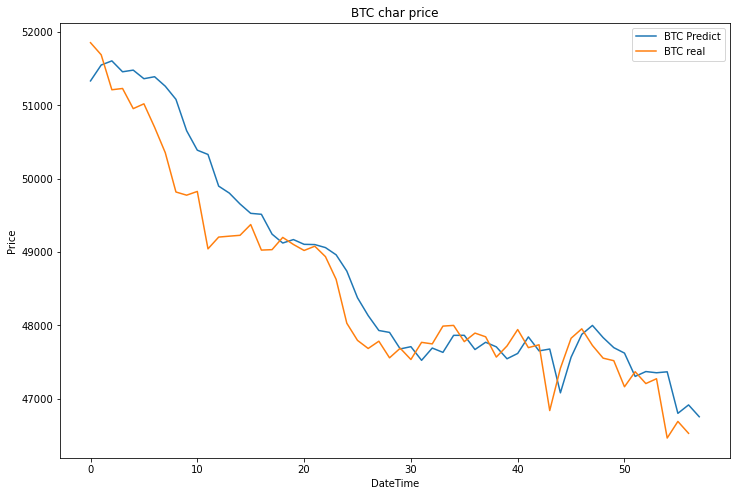

In [104]:

fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(BTC_predict, label = "BTC Predict");
ax.plot(data_Y_test, label = "BTC real");
ax.set(xlabel = "DateTime", ylabel = "Price", title = "BTC char price") # chưa thêm lại
ax.legend();